In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import os
import math
import random
import json
import cv2
import shutil

from PIL import Image
import time

import shapely.wkt as wkt
import shapely
from shapely.geometry import Polygon
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, accuracy_score
from keras import Sequential
from keras import layers
from keras.models import Model
from keras.applications.resnet50 import ResNet50
import tensorflow.keras.backend as K
from keras.models import load_model
import matplotlib.pyplot as plt

In [3]:
source_directory_train_images = "/content/drive/MyDrive/XBD/valid/images/"
source_directory_train_labels = "/content/drive/MyDrive/XBD/valid/labels/"
disasters_dir = "/content/drive/MyDrive/XBD/valid/disasters"
os.makedirs(disasters_dir, exist_ok=True)
cropped_images_dir="/content/drive/MyDrive/XBD/valid/cropped_images/"
disaster_csv_dir="/content/drive/MyDrive/XBD/valid/csv_files/"
os.makedirs(cropped_images_dir, exist_ok=True)
os.makedirs(disaster_csv_dir, exist_ok=True)

In [4]:
# run to seperate images and labels by disaster event name
#seperate data into disasters
def separate_data_to_disasters(source_dir,dest_dir,file_type):
    for filename in os.listdir(source_dir):
        disaster=filename.split('_')[0]
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(dest_dir,disaster,file_type, filename)
        destination_dir_path = os.path.join(dest_dir,disaster,file_type)
        os.makedirs(destination_dir_path, exist_ok=True)
        shutil.copyfile(source_path, destination_path)

# seperate images into disasters
separate_data_to_disasters(source_directory_train_images,disasters_dir,"images")
# seperate labels into disasters
separate_data_to_disasters(source_directory_train_labels,disasters_dir,"labels")

In [5]:
#Crop the image to buildings
def crop_images_to_polygons(img_array, polygon_pts):
    height, width, channels = img_array.shape
    # get x and y coordinates from the polygon points
    x_coords,y_coords = polygon_pts[:, 0],polygon_pts[:, 1]
    # minimum and maximum x and y coordinates
    xmin, xmax = np.min(x_coords), np.max(x_coords)
    ymin, ymax = np.min(y_coords), np.max(y_coords)
    # differences between maximum and minimum coordinates
    xdiff, ydiff = xmax - xmin, ymax - ymin
    # extend image by 80% of the width and height
    xmin = max(int(xmin - (xdiff * 0.8)), 0)
    xmax = min(int(xmax + (xdiff * 0.8)), width)
    ymin = max(int(ymin - (ydiff * 0.8)), 0)
    ymax = min(int(ymax + (ydiff * 0.8)), height)
    # Crop the image using the co-ordinates
    return img_array[ymin:ymax, xmin:xmax, :]

In [6]:
def process_label_data(images_dir, cropped_images_dir, disaster_csv_dir):
    disasters = [folder for folder in os.listdir(disasters_dir) if not folder.startswith('.')]
    # Encode damage labels to integers
    damage_labels = { 'un-classified' : 0, 'no-damage': 0 , 'minor-damage': 1, 'major-damage': 2, 'destroyed': 3 }
    for disaster in disasters:
        x_data = []
        y_data = []
        images_dir=os.path.join(disasters_dir, disaster,"images")
        labels_dir=os.path.join(disasters_dir, disaster,"labels")
        # Read Image and Label files and crop the buildings
        for image_name in os.listdir(images_dir):
            img_path = os.path.join(images_dir,image_name)
            img_obj = Image.open(img_path)
            img_array = np.array(img_obj)
            label_name = image_name.replace('.png', '.json')
            label_path = os.path.join(labels_dir,label_name)
            label_file = open(label_path)
            label_data = json.load(label_file)
            img_obj.close()
            label_file.close()
            for feat in label_data['features']['xy']:
                # get the damage type and building id
                damage_type = feat['properties'].get('subtype', 'no-damage')
                poly_uid = feat['properties']['uid']
                poly_uid += ".png"
                # add the damage label to y_data
                y_data.append(damage_labels[damage_type])
                # extract building shape in wkt format from json and convert to shapely object
                building_shape = wkt.loads(feat['wkt'])
                # extract building vertices/co-ordinates from shapely object
                polygon_pts = np.array(list(building_shape.exterior.coords))
                poly_img = crop_images_to_polygons(img_array, polygon_pts)
                # save the cropped image with building_id
                cv2.imwrite(os.path.join(cropped_images_dir,poly_uid), poly_img )
                # add building_id.png to x_data
                x_data.append(poly_uid)
        # save data into disaster_name.csv
        output_train_csv_path = os.path.join(disaster_csv_dir, f"{disaster}.csv")
        data_array = {'building_id': x_data, 'damage_level': y_data}
        df = pd.DataFrame(data = data_array)
        df.to_csv(output_train_csv_path)
process_label_data(disasters_dir, cropped_images_dir, disaster_csv_dir)

In [7]:
# F1 Score
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    # Recall
    recall = true_positives / (possible_positives + K.epsilon())
    # Precision
    precision = true_positives / (predicted_positives + K.epsilon())
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def ordinal_loss(y_true, y_pred):
    weights = K.cast(K.abs(K.argmax(y_true, axis=1) - K.argmax(y_pred, axis=1))/(K.int_shape(y_pred)[1] - 1), dtype='float32')
    return (1.0 + weights) * keras.losses.categorical_crossentropy(y_true, y_pred )

def classification_model():
    # Define the input layer with shape (128, 128, 3)
    inputs = layers.Input(shape=(128, 128, 3))

    # ResNet50 model pre-trained on ImageNet without the top layer
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

    # Freeze the layers of the base model so they are not trainable
    for layer in base_model.layers:
        layer.trainable = False

    # convolutional layer with 32 filters, 5x5 kernel size, and ReLU activation
    x = layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu')(inputs)
    # max pooling layer with pool size (2, 2)
    x = x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)

    # convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    # max pooling layer with pool size (2, 2)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)

    # convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    # pooling layer with pool size (2, 2)
    x = x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)

    # Flatten the output of the convolutional layers
    x = layers.Flatten()(x)

    # Pass the input through the base ResNet50 model and flatten its output
    base_resnet = base_model(inputs)
    base_resnet = layers.Flatten()(base_resnet)

    # Concatenate the output of the convolutional layers and the output of the base ResNet50 model
    concatenated_layers = layers.Concatenate()([x, base_resnet])

    # fully connected layer with 2024 neurons and ReLU activation
    x = layers.Dense(2024, activation='relu')(concatenated_layers)
    # fully connected layer with 524 neurons and ReLU activation
    x = layers.Dense(524, activation='relu')(x)
    # dropout layer with dropout rate 0.4
    x = layers.Dropout(0.4)(x)
    # fully connected layer with 124 neurons and ReLU activation
    x = layers.Dense(124, activation='relu')(x)
    # Output layer with 4 neurons for classification and softmax activation
    output = layers.Dense(4, activation='softmax')(x)

    # model with input and output layers
    model = Model(inputs=inputs, outputs=output)

    return model

In [8]:
def evaluate_model(model_path,cropped_images_dir,disaster_csv_dir):
    damage_labels = {0:"0", 1:"1", 2:"2", 3:"3"}
    # Load classification model
    model = classification_model()
    model.load_weights(model_path)

    adam = keras.optimizers.Adam(learning_rate=0.0001)
    # Compile the model with custom ordinal loss function
    model.compile(loss=ordinal_loss, optimizer=adam, metrics=['accuracy'])
    # Dictionary to store evaluation results for each disaster
    results={}
    # iterate over each CSV file in the disaster CSV directory
    for csv in os.listdir(disaster_csv_dir):
        disaster=csv.split(".")[0]
        test_csv=os.path.join(disaster_csv_dir, csv)
        # read CSV file into a pandas DataFrame
        df = pd.read_csv(test_csv)
        df = df.replace({"damage_level" : damage_labels })
        image_data = ImageDataGenerator(rescale=1/255.)
        # format image data for the model evaluation
        valid_data=image_data.flow_from_dataframe(dataframe=df,directory=cropped_images_dir,x_col='building_id',y_col='damage_level',batch_size=64,seed=123,class_mode="categorical",target_size=(128, 128))
        # make predictions
        predictions = model.predict(valid_data)
        val_trues = valid_data.classes
        val_pred = np.argmax(predictions, axis=-1)
        #accuracy and f1 score
        accuracy = accuracy_score(val_trues, val_pred)
        f1_weighted = f1_score(val_trues, val_pred, average='weighted')
        results[disaster]=[accuracy,f1_weighted]
    return results

In [9]:
#evaluate model trained on all disaster images
model_path="/content/drive/MyDrive/XBD/models/classification.hdf5"
results=evaluate_model(model_path,cropped_images_dir,disaster_csv_dir)

94765736/94765736 [==============================] - 5s 0us/step
Found 15582 validated image filenames belonging to 3 classes.
244/244 [==============================] - 74s 280ms/step
Found 5216 validated image filenames belonging to 4 classes.
82/82 [==============================] - 23s 276ms/step
Found 23670 validated image filenames belonging to 3 classes.
370/370 [==============================] - 97s 261ms/step
Found 9558 validated image filenames belonging to 4 classes.
150/150 [==============================] - 42s 280ms/step
Found 8444 validated image filenames belonging to 4 classes.
132/132 [==============================] - 39s 293ms/step
Found 14316 validated image filenames belonging to 4 classes.
224/224 [==============================] - 61s 274ms/step
Found 206 validated image filenames belonging to 4 classes.
4/4 [==============================] - 2s 614ms/step
Found 5668 validated image filenames belonging to 4 classes.
89/89 [==============================] - 26s 2

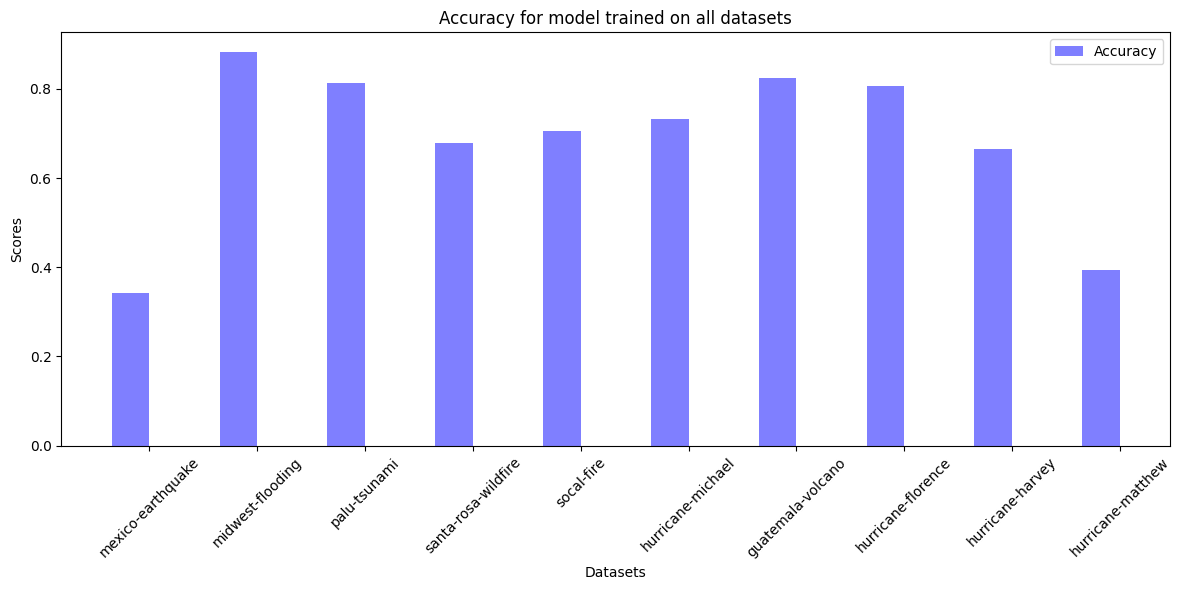

In [10]:
# Plot accuracy for each disaster
datasets = list(results.keys())
accuracy_scores = [score[0] for score in results.values()]

# Define width for each bar
bar_width = 0.35

# Calculate position for each dataset
r1 = range(len(datasets))

# Plotting Accuracy Scores
plt.figure(figsize=(12, 6))
plt.bar(r1, accuracy_scores, color='blue', alpha=0.5, width=bar_width, label='Accuracy')
plt.xlabel('Datasets')
plt.ylabel('Scores')
plt.title('Accuracy for model trained on all datasets')
plt.xticks([r + bar_width / 2 for r in range(len(datasets))], datasets, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Evaluating model trained on socal-fire images
model_path="/content/drive/MyDrive/XBD/train/socal_train/models/socal_trained_model.hdf5"
results=evaluate_model(model_path,cropped_images_dir,disaster_csv_dir)

Found 15582 validated image filenames belonging to 3 classes.
244/244 [==============================] - 66s 267ms/step
Found 5216 validated image filenames belonging to 4 classes.
82/82 [==============================] - 20s 249ms/step
Found 23670 validated image filenames belonging to 3 classes.
370/370 [==============================] - 119s 320ms/step
Found 9558 validated image filenames belonging to 4 classes.
150/150 [==============================] - 39s 257ms/step
Found 8444 validated image filenames belonging to 4 classes.
132/132 [==============================] - 35s 263ms/step
Found 14316 validated image filenames belonging to 4 classes.
224/224 [==============================] - 57s 254ms/step
Found 206 validated image filenames belonging to 4 classes.
4/4 [==============================] - 1s 189ms/step
Found 5668 validated image filenames belonging to 4 classes.
89/89 [==============================] - 24s 269ms/step
Found 14452 validated image filenames belonging to 4 c

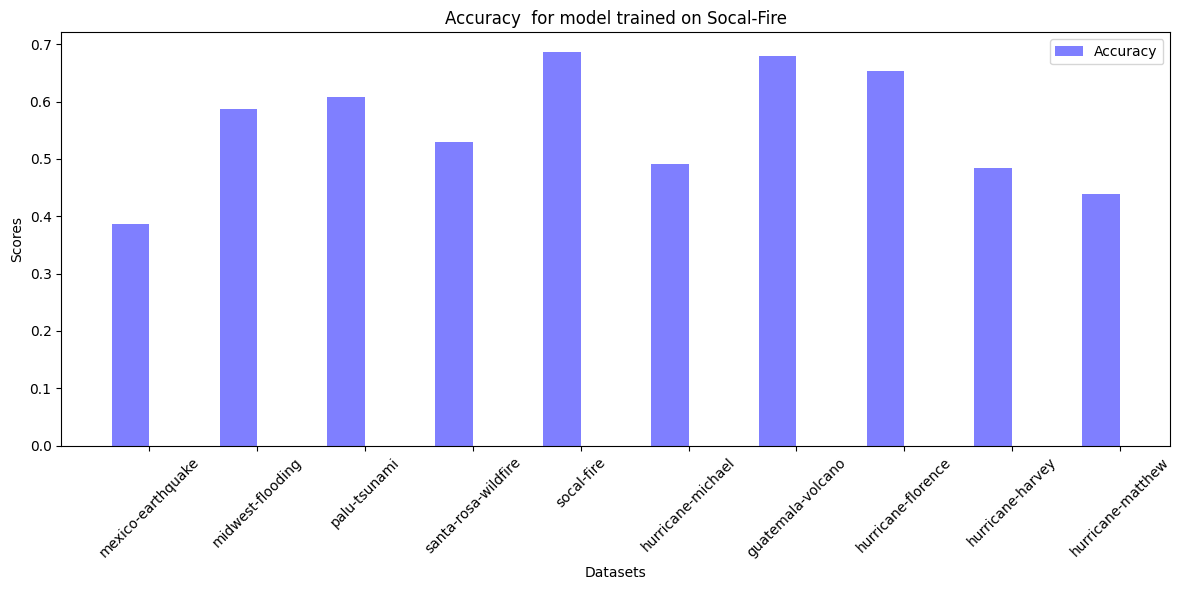

In [12]:
# Plot accuracy for each disaster evaluated on socal-fire model
datasets = list(results.keys())
accuracy_scores = [score[0] for score in results.values()]
bar_width = 0.35
r1 = range(len(datasets))
plt.figure(figsize=(12, 6))
plt.bar(r1, accuracy_scores, color='blue', alpha=0.5, width=bar_width, label='Accuracy')
plt.xlabel('Datasets')
plt.ylabel('Scores')
plt.title('Accuracy  for model trained on Socal-Fire')
plt.xticks([r + bar_width / 2 for r in range(len(datasets))], datasets, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Evaluating model trained on mexico-earthquake images
model_path="/content/drive/MyDrive/XBD/train/mexico_train/mexico_train_model.hdf5"
mexico_results=evaluate_model(model_path,cropped_images_dir,disaster_csv_dir)

Found 15582 validated image filenames belonging to 3 classes.
244/244 [==============================] - 65s 264ms/step
Found 5216 validated image filenames belonging to 4 classes.
82/82 [==============================] - 20s 249ms/step
Found 23670 validated image filenames belonging to 3 classes.
370/370 [==============================] - 93s 251ms/step
Found 9558 validated image filenames belonging to 4 classes.
150/150 [==============================] - 40s 263ms/step
Found 8444 validated image filenames belonging to 4 classes.
132/132 [==============================] - 35s 266ms/step
Found 14316 validated image filenames belonging to 4 classes.
224/224 [==============================] - 58s 259ms/step
Found 206 validated image filenames belonging to 4 classes.
4/4 [==============================] - 1s 233ms/step
Found 5668 validated image filenames belonging to 4 classes.
89/89 [==============================] - 23s 257ms/step
Found 14452 validated image filenames belonging to 4 cl

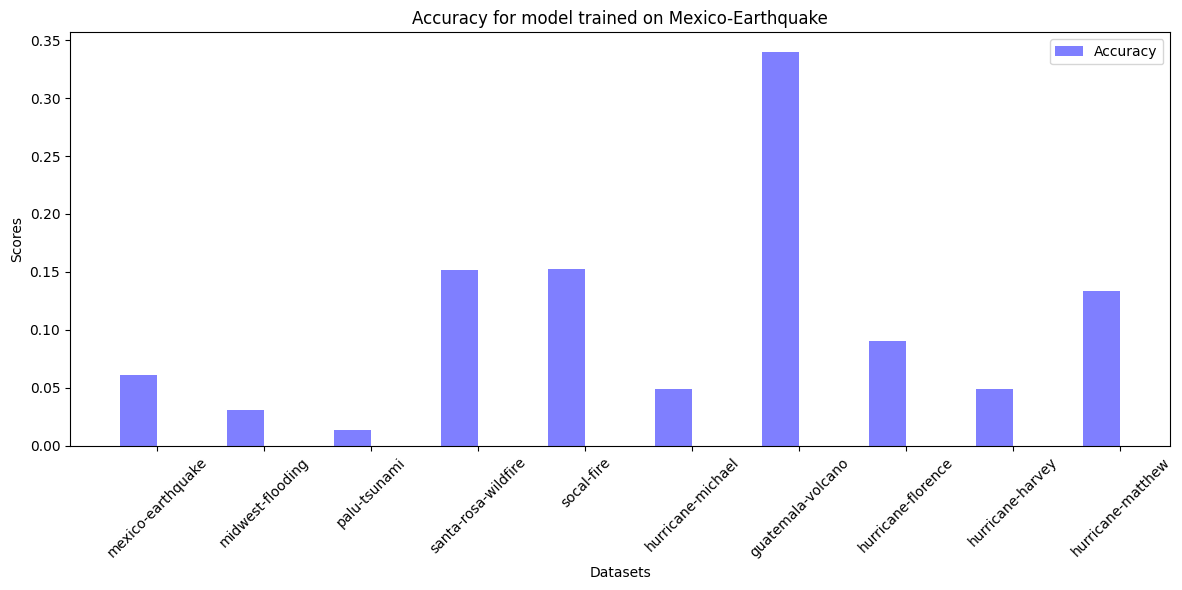

In [14]:
# Plot accuracy for each disaster evaluated on mexico-earthquake model
datasets = list(mexico_results.keys())
mexico_accuracy_scores = [score[0] for score in mexico_results.values()]
bar_width = 0.35
r1 = range(len(datasets))
plt.figure(figsize=(12, 6))
plt.bar(r1, mexico_accuracy_scores, color='blue', alpha=0.5, width=bar_width, label='Accuracy')
plt.xlabel('Datasets')
plt.ylabel('Scores')
plt.title('Accuracy for model trained on Mexico-Earthquake')
plt.xticks([r + bar_width / 2 for r in range(len(datasets))], datasets, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()